<a href="https://colab.research.google.com/github/devkaps-tech/Siamese_Netowrk/blob/main/Siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

In [2]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

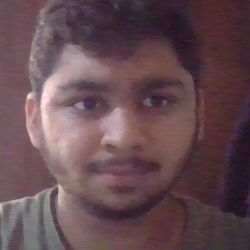

In [3]:
Image.open("/content/drive/MyDrive/AIR/data/positive/cec68081-4871-11ed-a304-b068e64dc175.jpg")

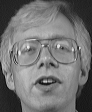

In [4]:
Image.open("/content/drive/MyDrive/archive/s2/5.pgm")

In [5]:
img = read_image('/content/drive/MyDrive/archive/s2/5.pgm')
img.shape

(112, 92)

In [6]:
size = 2
total_sample_size = 10000


def get_data(size, total_sample_size):
    #read the image
    image = read_image('/content/drive/MyDrive/archive/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2]) # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('/content/drive/MyDrive/archive/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('/content/drive/MyDrive/archive/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('/content/drive/MyDrive/archive/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('/content/drive/MyDrive/archive/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [7]:
X, Y = get_data(size, total_sample_size)

X.shape

(20000, 2, 1, 56, 46)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.50)

In [9]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          padding='same', data_format="channels_first"))
    
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.50))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, padding='same', data_format="channels_first"))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first")) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [10]:
def initialize_base_network1():
  input_dim = x_train.shape[2:]

  input = Input(shape=input_dim, name="base_input")
  x = Flatten(name="flatten_input")(input)
  x = Dense(128, activation='relu', name="first_base_dense")(x)
  x = Dropout(0.1, name="first_dropout")(x)
  x = Dense(128, activation='relu', name="second_base_dense")(x)
  x = Dropout(0.1, name="second_dropout")(x)
  x = Dense(128, activation='relu', name="third_base_dense")(x)

  return Model(inputs=input, outputs=x)


In [11]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

base_network = initialize_base_network1()
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [12]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [13]:
epochs = 23
rms = RMSprop()

model = Model(inputs=[img_a, img_b], outputs=distance)

In [14]:
def contrastive_loss(y_true, y_pred):
    margin = 2
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

model.compile(loss=contrastive_loss, optimizer=rms)

In [15]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1] 

history =model.fit([img_1, img_2], y_train, validation_split=.25, batch_size=128, verbose=2, epochs=epochs)

Epoch 1/23
59/59 - 3s - loss: 1.0405 - val_loss: 0.6610 - 3s/epoch - 53ms/step
Epoch 2/23
59/59 - 0s - loss: 0.6648 - val_loss: 0.5912 - 370ms/epoch - 6ms/step
Epoch 3/23
59/59 - 0s - loss: 0.5801 - val_loss: 0.4268 - 317ms/epoch - 5ms/step
Epoch 4/23
59/59 - 0s - loss: 0.5255 - val_loss: 0.3290 - 308ms/epoch - 5ms/step
Epoch 5/23
59/59 - 0s - loss: 0.4866 - val_loss: 0.3386 - 397ms/epoch - 7ms/step
Epoch 6/23
59/59 - 0s - loss: 0.4496 - val_loss: 0.2944 - 305ms/epoch - 5ms/step
Epoch 7/23
59/59 - 0s - loss: 0.4402 - val_loss: 0.4080 - 304ms/epoch - 5ms/step
Epoch 8/23
59/59 - 0s - loss: 0.3996 - val_loss: 0.2540 - 311ms/epoch - 5ms/step
Epoch 9/23
59/59 - 0s - loss: 0.3950 - val_loss: 0.2386 - 379ms/epoch - 6ms/step
Epoch 10/23
59/59 - 0s - loss: 0.3710 - val_loss: 0.3135 - 398ms/epoch - 7ms/step
Epoch 11/23
59/59 - 0s - loss: 0.3680 - val_loss: 0.2957 - 319ms/epoch - 5ms/step
Epoch 12/23
59/59 - 0s - loss: 0.3428 - val_loss: 0.2536 - 292ms/epoch - 5ms/step
Epoch 13/23
59/59 - 0s - lo

In [16]:
x_test[0]

array([[[[0.46666667, 0.47058824, 0.47058824, ..., 0.49019608,
          0.48235294, 0.50196078],
         [0.47058824, 0.4627451 , 0.46666667, ..., 0.50196078,
          0.49803922, 0.50196078],
         [0.47058824, 0.45882353, 0.4627451 , ..., 0.50588235,
          0.49019608, 0.48235294],
         ...,
         [0.22745098, 0.25098039, 0.26666667, ..., 0.36078431,
          0.36470588, 0.38039216],
         [0.24705882, 0.25098039, 0.25098039, ..., 0.35294118,
          0.35686275, 0.36470588],
         [0.25098039, 0.22745098, 0.23921569, ..., 0.36470588,
          0.36470588, 0.35294118]]],


       [[[0.09019608, 0.10196078, 0.09019608, ..., 0.0745098 ,
          0.07843137, 0.0745098 ],
         [0.09019608, 0.09803922, 0.10196078, ..., 0.0745098 ,
          0.09019608, 0.07058824],
         [0.10196078, 0.10196078, 0.09803922, ..., 0.07843137,
          0.07843137, 0.09019608],
         ...,
         [0.76078431, 0.74901961, 0.70980392, ..., 0.60784314,
          0.61176471, 0

In [17]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

313/313 [==============================] - 1s 2ms/step


In [18]:
model.predict([x_test[0] , x_test[1]])

1/1 [==============================] - 0s 15ms/step


array([[1.1790073],
       [1.7947761]], dtype=float32)

In [20]:
x_train[0].shape

(2, 1, 56, 46)

In [21]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [22]:
compute_accuracy(pred, y_test)

0.973305954825462

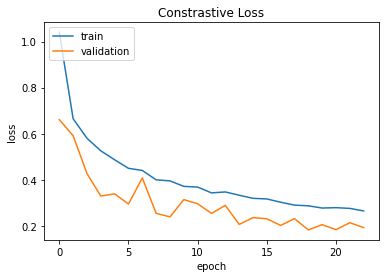

In [23]:
import matplotlib.pyplot as plt
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()




# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [24]:
size = 2
total_sample_size = 10000


def get_data(size, total_sample_size):
    #read the image
    image = read_image('/content/drive/MyDrive/test_archive/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2]) # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('/content/drive/MyDrive/test_archive/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('/content/drive/MyDrive/test_archive/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('/content/drive/MyDrive/test_archive/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('/content/drive/MyDrive/test_archive/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [ ]:
X, Y = get_data(size, total_sample_size)

X.shape